In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from soiltextureplot.plotting import plot_soil_texture_classes, plot_soil_samples
import mpltern

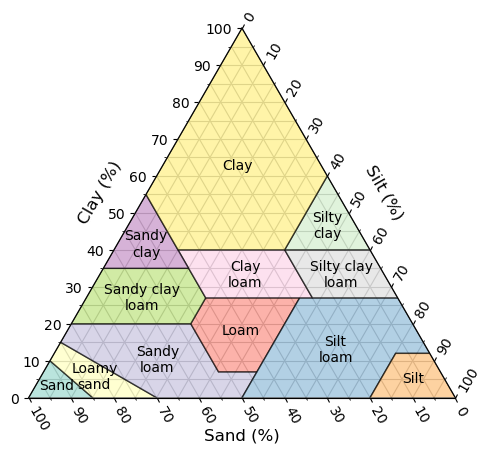

In [2]:
ax = plt.subplot(projection="ternary", ternary_sum=100.0)
plot_soil_texture_classes(ax)
plt.show()


In [3]:
# example dataset
example_df = pd.DataFrame(
    {
        "sample_id": ["S1", "S2", "S3", "S4", "S5"],
        "sand": [65, 70, 75, 80, 35],
        "silt": [20, 24, 21, 16, 45],
        "clay": [15, 6, 4, 4, 20],
        "BD": [1.002, 1.277, 1.008, 1.927, 1.774],
    }
)

In [4]:
# Check texture classes from soiltexture package
from soiltexture import getTexture
example_df.apply(
    lambda row: getTexture(row['sand'], row['clay']), axis=1
)

0    sandy loam
1    sandy loam
2    loamy sand
3    loamy sand
4          loam
dtype: object

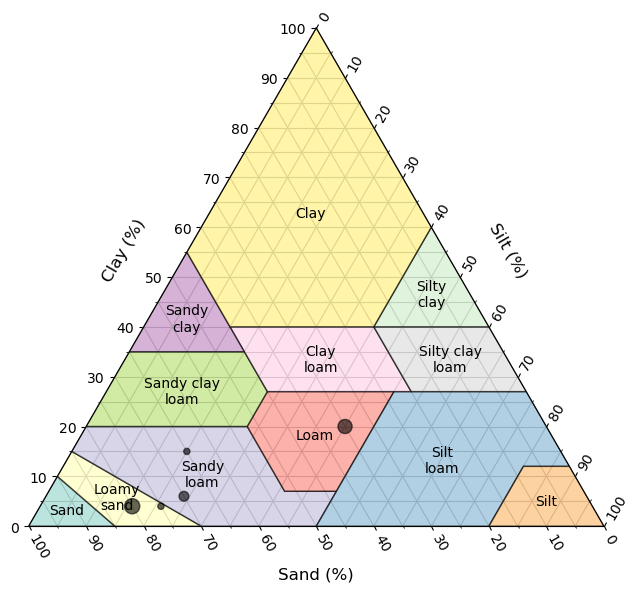

In [5]:
fig, ax = plot_soil_samples(example_df, size_by="BD")
plt.show()